In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm

In [2]:
training_df = pd.read_csv(os.path.join('datalake/datasets', 'train_state_CA.csv'))
training_df.head(3)

,Month-Year,Part Number,State,Units sold per Part
0,2014-04-01,DS1010,CA,2.0
1,2014-05-01,DS1010,CA,1.0
2,2014-06-01,DS1010,CA,3.0


In [3]:
df = training_df[training_df['Part Number']=='DS1439']
df = df.drop(['Part Number','State'], axis=1)
df.head(3)

,Month-Year,Units sold per Part
1518,2014-04-01,18.0
1519,2014-05-01,14.0
1520,2014-06-01,12.0


In [4]:
df.describe()

,Units sold per Part
count,57.000000
mean,15.578947
std,9.597149
min,2.000000
25%,10.000000
50%,14.000000
75%,18.000000
max,61.000000


In [5]:
len_train = len(df['Units sold per Part'])-12

train = df[:len_train]
test = df[len_train:]

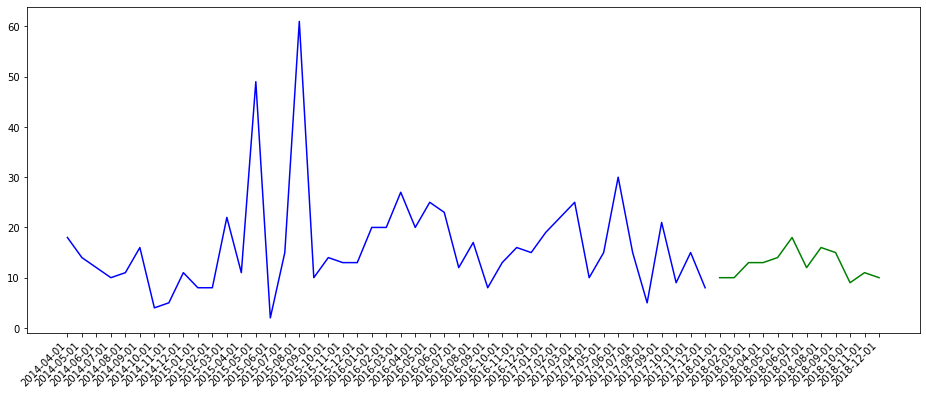

In [6]:
plt.figure(figsize=(16,6))
plt.xticks(rotation=45, ha="right")
plt.plot(train['Month-Year'], train['Units sold per Part'],color='blue')
plt.plot(test['Month-Year'], test['Units sold per Part'],color='green')

In [7]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(train['Units sold per Part'])

(0.41116909845643923, True)

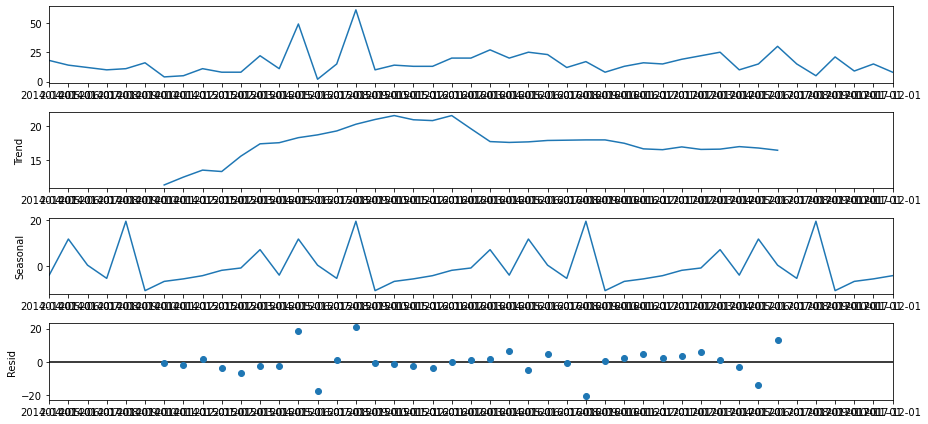

In [8]:
import statsmodels.api as sm
from pylab import rcParams

extract = train.set_index('Month-Year')
rcParams['figure.figsize'] = 13, 6
decomposition = sm.tsa.seasonal_decompose(extract, model='additive', period=12)
fig = decomposition.plot()
plt.show()

In [9]:
model = pm.auto_arima(train['Units sold per Part'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=371.279, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=358.948, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=369.288, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=343.509, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=344.984, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=344.429, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=341.533, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=356.960, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=343.004, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=342.445, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec

B

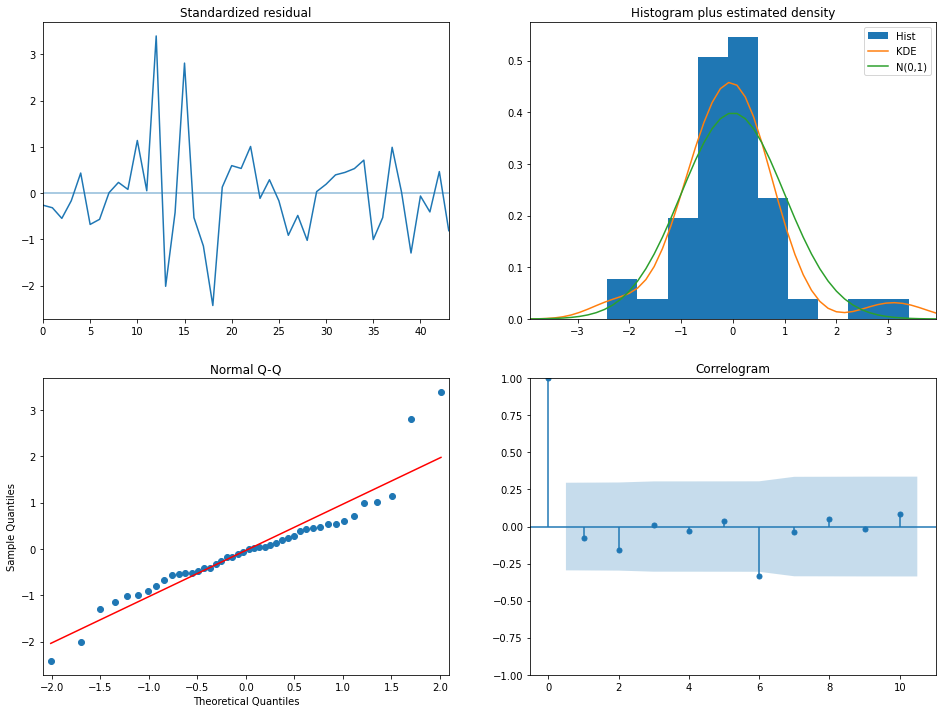

In [10]:
model.plot_diagnostics(figsize=(16,12))
plt.show()

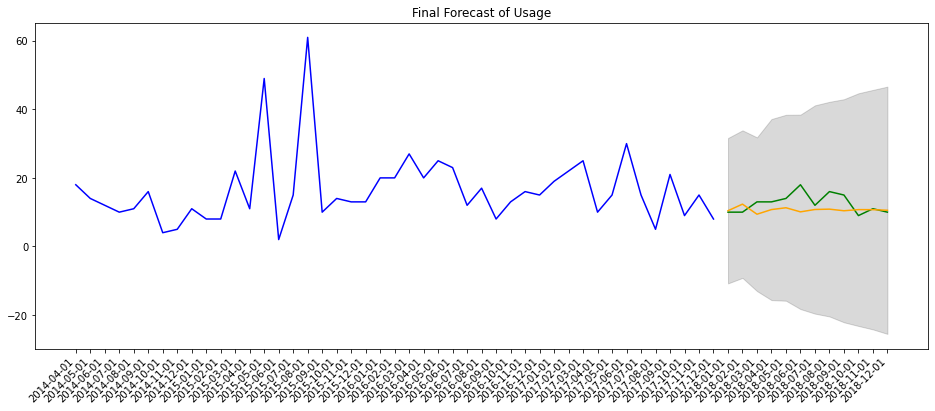

In [11]:
# Forecast
n_periods = 12
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(train['Units sold per Part']), len(train['Units sold per Part'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16,6))
plt.xticks(rotation=45, ha="right")
plt.plot(train['Month-Year'],train['Units sold per Part'],color='blue')
plt.plot(test['Month-Year'],test['Units sold per Part'],color='green')
plt.plot(fc_series, color='orange')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Usage")
plt.show()

In [12]:
# Accuracy metrics
def compute_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast = fc
actual = np.array(test['Units sold per Part'])
accuracy = compute_accuracy(forecast, actual)
print(f"forecast: {forecast}")
print(f"actual: {actual}")
print(f"accuracy: {accuracy}")

forecast: [10.42087046 12.342452    9.39916278 10.75386039 11.28364103 10.08719224
 10.77867226 10.8777344  10.40856542 10.74059956 10.72915867 10.55261358]
actual: [10. 10. 13. 13. 14. 18. 12. 16. 15.  9. 11. 10.]
accuracy: {'mape': 0.1967519638158264, 'me': -1.8854564333720987, 'mae': 2.728212368125872, 'mpe': -0.10925303781408936, 'rmse': 3.4867064123987097, 'corr': -0.30485414480769046, 'minmax': 0.1900525756918241}
